In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import KFold
from tqdm import tqdm
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2 as ToTensor
import time
from torch.amp import GradScaler
from torchvision import models
from efficientnet_pytorch import EfficientNet
import warnings

warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
!pip install -U albumentations

  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.19
    Uninstalling albumentations-1.4.19:
      Successfully uninstalled albumentations-1.4.19


In [ ]:
albumentations_transforms=A.Compose([A.HorizontalFlip(p=.5),
                           A.ShiftScaleRotate(rotate_limit=2,value=0,
                                              border_mode=cv2.BORDER_CONSTANT, p=.5),

                           A.OneOf(
                                   [A.CLAHE(clip_limit=1),
                                    A.RandomBrightnessContrast(),
                                   ],p=.5),
                           A.GaussNoise(var_limit=(10,100),mean=np.random.choice([-5,-4,-3,-2,-1,0,1,2,3,4,5]),p=.5),
                           A.Resize(height=224, width=224),
                           A.Normalize(),
                           ToTensor()])

In [ ]:
class Transform():
    def __init__(self,transform):
       self.transform=transform
    def __call__(self,image):
       return self.transform(image=np.array(image))["image"]



train_dir = 'C:/Users/ProArt/Desktop/DATASET/TRAIN'
# train_dataset = ImageFolder(train_dir, transform=data_transforms) # used for torchvision.transforms to augment images
train_dataset = ImageFolder(train_dir, transform=Transform(albumentations_transforms)) # used for albumentations to augment images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8129121..1.056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.59371525..0.8886797].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8471616..0.81199133].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8471616..1.056].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8471616..1.0420567].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8471616..0.9723398].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81976193..1.

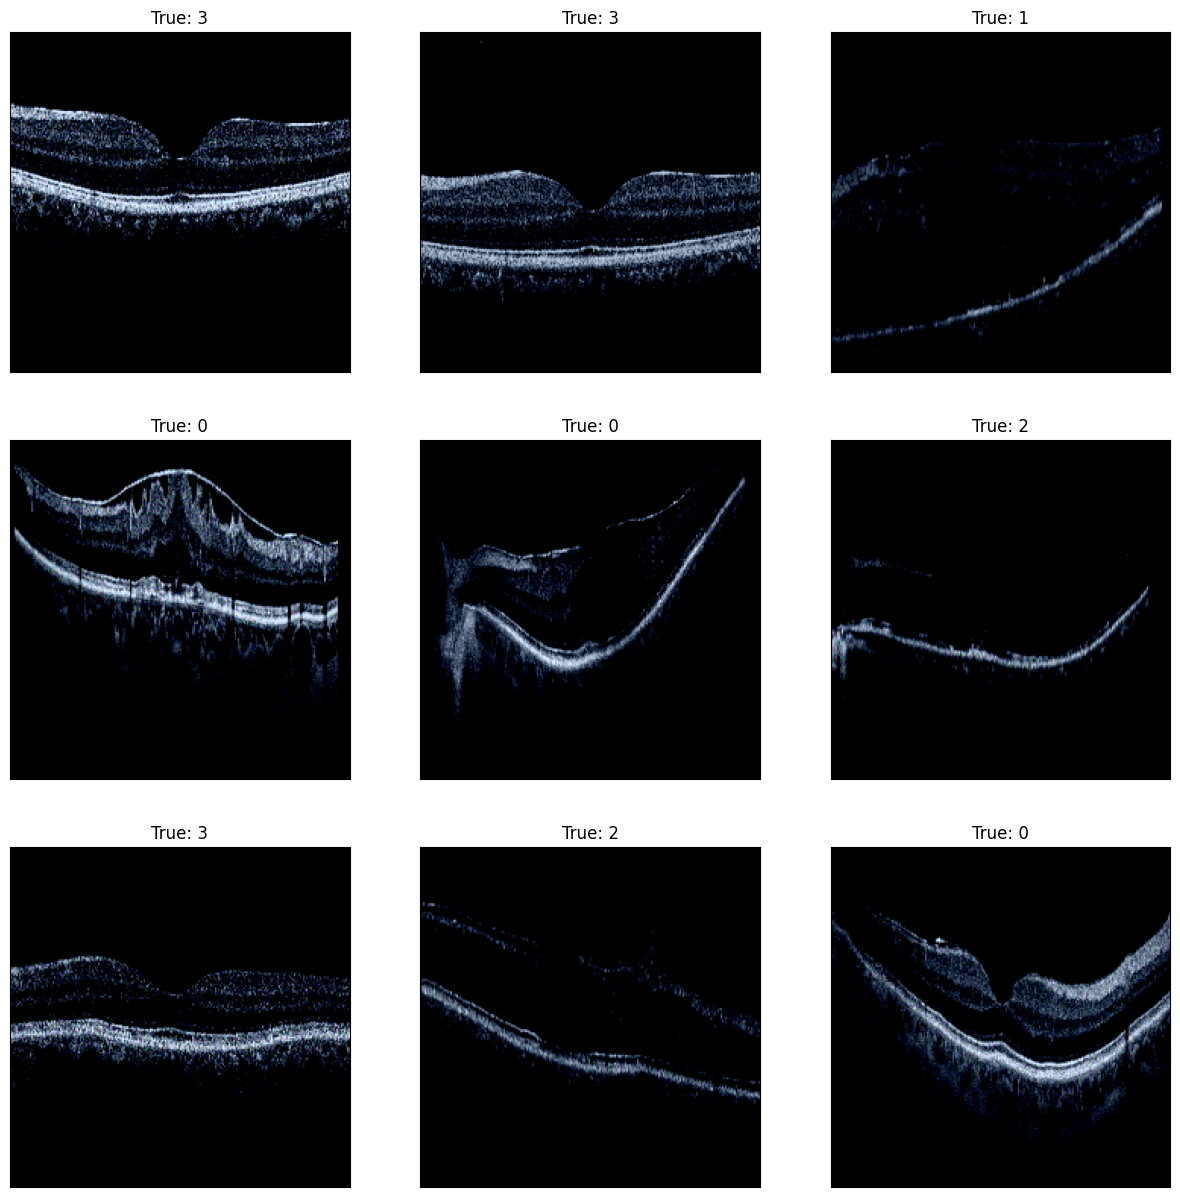

'\nlabels - Diseases\n0 - epiretinal membrane (ERM)\n1 - full-thicknes macular hole (FTMH)\n2 - lamellar macular hole (LMH)\n3 - normal OCT\n4 - vitreomacular traction (VMT) \n'

In [ ]:
visualize_images = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Visualise some examples
plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    batch = next(iter(visualize_images))
    label = int(batch[1].numpy()[0])
    image = np.transpose(batch[0][0].numpy(), (1, 2, 0))/2.5
    plt.imshow(image, vmin = 0, vmax = 255)
    plt.title("True: {}".format(label))
plt.show()

"""
labels - Diseases
0 - epiretinal membrane (ERM)
1 - full-thicknes macular hole (FTMH)
2 - lamellar macular hole (LMH)
3 - normal OCT
4 - vitreomacular traction (VMT)
"""


In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()

        self.resnet = models.resnet50(pretrained=True)
        self.efficientnet = EfficientNet.from_pretrained("efficientnet-b0")


        self.resnet.fc = nn.Identity()
        self.efficientnet._fc = nn.Identity()

        resnet_output_dim = 2048
        efficientnet_output_dim = 1280

        self.fc = nn.Sequential(
            nn.Linear(resnet_output_dim + efficientnet_output_dim, 128),
            nn.ReLU(),
            # nn.Dropout(p=.2),
            nn.Linear(128, num_classes)
            )

    def forward(self, x):

        resnet_out = self.resnet(x)  # Shape: (batch_size, resnet_channels)
        efficientnet_out = self.efficientnet(x)  # Shape: (batch_size, efficientnet_channels)


        combined_features = torch.cat((resnet_out, efficientnet_out), dim=1)  # Shape: (batch_size, combined_channels)

        # Classify
        output = self.fc(combined_features)  # Shape: (batch_size, num_classes)
        return output

In [ ]:
model = CombinedModel(num_classes=5)
model.to(device)

Loaded pretrained weights for efficientnet-b0


CombinedModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [ ]:
def train_model(train_loader, model, criterion, optimizer, scaler, device):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    itr = 0
    accumulation_steps = 64 // len(train_loader)

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).to(device)
        loss = criterion(outputs, labels)
        loss = loss / accumulation_steps
        # loss.backward()
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        #Gradient Accumulation
        if (itr + 1 ) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        itr += 1

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return train_loss / len(train_loader), correct / total

In [ ]:
def cross_validation(val_loader, model, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).to(device)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            # print(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return val_loss / len(val_loader), correct / total

In [ ]:
monte_carlo_iter = 10
scores = {}
for itr in range(monte_carlo_iter):
    kfold = KFold(n_splits = 2, shuffle=True, random_state=itr)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    print(f"----------- Monte Carlo Iteration: {itr + 1} -------------\n")

    # K-fold CV
    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
        start = time.strftime("%H:%M:%S")
        print(f"----------- Fold: {fold + 1}  --- time: {start} -----------")

        train_subset = Subset(train_dataset, train_idx)
        val_subset = Subset(train_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
        scaler = GradScaler()
        scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=3, verbose=True)


        n_epoch_stop = 10
        best_val_loss = float('inf')
        val_no_improve = 0
        max_epoch_num = 100
        for epoch in range(max_epoch_num):
            train_loss, train_acc = train_model(train_loader, model, criterion, optimizer, scaler, device)
            val_loss, val_acc = cross_validation(val_loader, model, criterion,device)
            scheduler.step(val_loss)
            print(f'Epoch [{epoch + 1}/{max_epoch_num}]: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                val_no_improve = 0
                save_path = f'./model-fold-{fold}.pth'
                torch.save(model.state_dict(), save_path)
            else:
                val_no_improve += 1

            if val_no_improve >= n_epoch_stop:
                print("Early stopping.")
                break

    print('Cross-validation done.')
    key=str("Monte-Carlo-iter-"+str(itr))
    scores[key] = ([train_losses, val_losses,train_accuracies, val_accuracies])

----------- Monte Carlo Iteration: 1 -------------

----------- Fold: 1  --- time: 13:24:43 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.24it/s]


Epoch [1/100]: Train Loss: 0.2945, Train Acc: 0.4083, Val Loss: 1.3206, Val Acc: 0.4861


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.74it/s]


Epoch [2/100]: Train Loss: 0.2198, Train Acc: 0.6778, Val Loss: 0.9888, Val Acc: 0.7222


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.22it/s]


Epoch [3/100]: Train Loss: 0.1655, Train Acc: 0.7806, Val Loss: 0.7281, Val Acc: 0.7944


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.90it/s]


Epoch [4/100]: Train Loss: 0.1115, Train Acc: 0.8083, Val Loss: 0.5072, Val Acc: 0.8306


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.33it/s]


Epoch [5/100]: Train Loss: 0.0779, Train Acc: 0.9056, Val Loss: 0.3310, Val Acc: 0.9222


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  4.00it/s]


Epoch [6/100]: Train Loss: 0.0499, Train Acc: 0.9583, Val Loss: 0.1777, Val Acc: 0.9528


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.40it/s]


Epoch [7/100]: Train Loss: 0.0282, Train Acc: 0.9806, Val Loss: 0.1161, Val Acc: 0.9667


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.90it/s]


Epoch [8/100]: Train Loss: 0.0183, Train Acc: 0.9806, Val Loss: 0.0846, Val Acc: 0.9722


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.35it/s]


Epoch [9/100]: Train Loss: 0.0103, Train Acc: 0.9917, Val Loss: 0.1055, Val Acc: 0.9611


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.71it/s]


Epoch [10/100]: Train Loss: 0.0178, Train Acc: 0.9944, Val Loss: 0.1041, Val Acc: 0.9722


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.23it/s]


Epoch [11/100]: Train Loss: 0.0067, Train Acc: 0.9944, Val Loss: 0.0988, Val Acc: 0.9639


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.28it/s]


Epoch [12/100]: Train Loss: 0.0043, Train Acc: 1.0000, Val Loss: 0.0483, Val Acc: 0.9833


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.85it/s]


Epoch [13/100]: Train Loss: 0.0022, Train Acc: 0.9972, Val Loss: 0.0582, Val Acc: 0.9750


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.98it/s]


Epoch [14/100]: Train Loss: 0.0030, Train Acc: 1.0000, Val Loss: 0.0758, Val Acc: 0.9833


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.12it/s]


Epoch [15/100]: Train Loss: 0.0028, Train Acc: 0.9944, Val Loss: 0.0653, Val Acc: 0.9833


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.05it/s]


Epoch [16/100]: Train Loss: 0.0020, Train Acc: 1.0000, Val Loss: 0.0476, Val Acc: 0.9833


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.06it/s]


Epoch [17/100]: Train Loss: 0.0010, Train Acc: 0.9972, Val Loss: 0.0326, Val Acc: 0.9917


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.00it/s]


Epoch [18/100]: Train Loss: 0.0005, Train Acc: 1.0000, Val Loss: 0.0781, Val Acc: 0.9861


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.31it/s]


Epoch [19/100]: Train Loss: 0.0041, Train Acc: 0.9917, Val Loss: 0.0460, Val Acc: 0.9917


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.14it/s]


Epoch [20/100]: Train Loss: 0.0006, Train Acc: 1.0000, Val Loss: 0.0386, Val Acc: 0.9861


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.32it/s]


Epoch [21/100]: Train Loss: 0.0177, Train Acc: 0.9917, Val Loss: 0.0963, Val Acc: 0.9833


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.18it/s]


Epoch [22/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0850, Val Acc: 0.9806


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.88it/s]


Epoch [23/100]: Train Loss: 0.0027, Train Acc: 0.9972, Val Loss: 0.1079, Val Acc: 0.9778


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.18it/s]


Epoch [24/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0656, Val Acc: 0.9861


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.13it/s]


Epoch [25/100]: Train Loss: 0.0152, Train Acc: 0.9944, Val Loss: 0.0694, Val Acc: 0.9778


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.11it/s]


Epoch [26/100]: Train Loss: 0.0004, Train Acc: 1.0000, Val Loss: 0.0889, Val Acc: 0.9833


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.42it/s]


Epoch [27/100]: Train Loss: 0.0040, Train Acc: 0.9972, Val Loss: 0.0957, Val Acc: 0.9778
Early stopping.
----------- Fold: 2  --- time: 13:27:47 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.02it/s]


Epoch [1/100]: Train Loss: 0.0684, Train Acc: 0.9667, Val Loss: 0.0015, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.16it/s]


Epoch [2/100]: Train Loss: 0.0201, Train Acc: 0.9778, Val Loss: 0.0002, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.84it/s]


Epoch [3/100]: Train Loss: 0.0028, Train Acc: 0.9944, Val Loss: 0.0070, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.98it/s]


Epoch [4/100]: Train Loss: 0.0156, Train Acc: 0.9861, Val Loss: 0.0456, Val Acc: 0.9917


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.99it/s]


Epoch [5/100]: Train Loss: 0.0053, Train Acc: 0.9944, Val Loss: 0.0138, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.56it/s]


Epoch [6/100]: Train Loss: 0.0066, Train Acc: 0.9972, Val Loss: 0.0002, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.84it/s]


Epoch [7/100]: Train Loss: 0.0035, Train Acc: 0.9972, Val Loss: 0.0003, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.84it/s]


Epoch [8/100]: Train Loss: 0.0019, Train Acc: 0.9944, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.02it/s]


Epoch [9/100]: Train Loss: 0.0046, Train Acc: 0.9944, Val Loss: 0.0066, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.96it/s]


Epoch [10/100]: Train Loss: 0.0084, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.08it/s]


Epoch [11/100]: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.77it/s]


Epoch [12/100]: Train Loss: 0.0007, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.83it/s]


Epoch [13/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0002, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.76it/s]


Epoch [14/100]: Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0053, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.71it/s]


Epoch [15/100]: Train Loss: 0.0295, Train Acc: 0.9917, Val Loss: 0.0140, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.07it/s]


Epoch [16/100]: Train Loss: 0.0005, Train Acc: 1.0000, Val Loss: 0.0222, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.02it/s]


Epoch [17/100]: Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.69it/s]


Epoch [18/100]: Train Loss: 0.0031, Train Acc: 0.9972, Val Loss: 0.0116, Val Acc: 0.9944


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.81it/s]


Epoch [19/100]: Train Loss: 0.0068, Train Acc: 0.9944, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.79it/s]


Epoch [20/100]: Train Loss: 0.0212, Train Acc: 0.9917, Val Loss: 0.0001, Val Acc: 1.0000
Early stopping.
Cross-validation done.
----------- Monte Carlo Iteration: 2 -------------

----------- Fold: 1  --- time: 13:30:03 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.22it/s]


Epoch [1/100]: Train Loss: 0.0172, Train Acc: 0.9944, Val Loss: 0.0005, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.17it/s]


Epoch [2/100]: Train Loss: 0.0049, Train Acc: 0.9944, Val Loss: 0.0320, Val Acc: 0.9944


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.20it/s]


Epoch [3/100]: Train Loss: 0.0053, Train Acc: 0.9972, Val Loss: 0.0012, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  4.00it/s]


Epoch [4/100]: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0496, Val Acc: 0.9889


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.24it/s]


Epoch [5/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.11it/s]


Epoch [6/100]: Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.05it/s]


Epoch [7/100]: Train Loss: 0.0019, Train Acc: 0.9972, Val Loss: 0.0008, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.18it/s]


Epoch [8/100]: Train Loss: 0.0024, Train Acc: 0.9972, Val Loss: 0.0040, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.21it/s]


Epoch [9/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0067, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.25it/s]


Epoch [10/100]: Train Loss: 0.0129, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.90it/s]


Epoch [11/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.99it/s]


Epoch [12/100]: Train Loss: 0.0368, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.16it/s]


Epoch [13/100]: Train Loss: 0.0036, Train Acc: 0.9972, Val Loss: 0.0262, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.41it/s]


Epoch [14/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.16it/s]


Epoch [15/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0132, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.97it/s]


Epoch [16/100]: Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.13it/s]


Epoch [17/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.32it/s]


Epoch [18/100]: Train Loss: 0.0253, Train Acc: 0.9944, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.91it/s]


Epoch [19/100]: Train Loss: 0.0073, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.16it/s]


Epoch [20/100]: Train Loss: 0.0072, Train Acc: 0.9972, Val Loss: 0.0435, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.11it/s]


Epoch [21/100]: Train Loss: 0.0073, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000
Early stopping.
----------- Fold: 2  --- time: 13:32:25 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.75it/s]


Epoch [1/100]: Train Loss: 0.0067, Train Acc: 0.9917, Val Loss: 0.0430, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.05it/s]


Epoch [2/100]: Train Loss: 0.0009, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.99it/s]


Epoch [3/100]: Train Loss: 0.0162, Train Acc: 0.9861, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.99it/s]


Epoch [4/100]: Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.69it/s]


Epoch [5/100]: Train Loss: 0.0227, Train Acc: 0.9861, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.72it/s]


Epoch [6/100]: Train Loss: 0.0021, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.78it/s]


Epoch [7/100]: Train Loss: 0.0051, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.99it/s]


Epoch [8/100]: Train Loss: 0.0031, Train Acc: 0.9972, Val Loss: 0.0006, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.06it/s]


Epoch [9/100]: Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.78it/s]


Epoch [10/100]: Train Loss: 0.0207, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.69it/s]


Epoch [11/100]: Train Loss: 0.0014, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.96it/s]


Epoch [12/100]: Train Loss: 0.0077, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.83it/s]


Epoch [13/100]: Train Loss: 0.0282, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.94it/s]


Epoch [14/100]: Train Loss: 0.0006, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.74it/s]


Epoch [15/100]: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.95it/s]


Epoch [16/100]: Train Loss: 0.0200, Train Acc: 0.9889, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.90it/s]


Epoch [17/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.65it/s]


Epoch [18/100]: Train Loss: 0.0487, Train Acc: 0.9917, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.82it/s]


Epoch [19/100]: Train Loss: 0.0061, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.83it/s]


Epoch [20/100]: Train Loss: 0.0624, Train Acc: 0.9917, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.88it/s]


Epoch [21/100]: Train Loss: 0.0192, Train Acc: 0.9889, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.75it/s]


Epoch [22/100]: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.78it/s]


Epoch [23/100]: Train Loss: 0.0102, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.94it/s]


Epoch [24/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0012, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.98it/s]


Epoch [25/100]: Train Loss: 0.0041, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.98it/s]


Epoch [26/100]: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.28it/s]


Epoch [27/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.84it/s]


Epoch [28/100]: Train Loss: 0.0007, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000
Early stopping.
Cross-validation done.
----------- Monte Carlo Iteration: 3 -------------

----------- Fold: 1  --- time: 13:35:36 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.75it/s]


Epoch [1/100]: Train Loss: 0.0028, Train Acc: 0.9972, Val Loss: 0.0002, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.30it/s]


Epoch [2/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0486, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.75it/s]


Epoch [3/100]: Train Loss: 0.0044, Train Acc: 0.9972, Val Loss: 0.0027, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.14it/s]


Epoch [4/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0060, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.07it/s]


Epoch [5/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.98it/s]


Epoch [6/100]: Train Loss: 0.0021, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.19it/s]


Epoch [7/100]: Train Loss: 0.0010, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.98it/s]


Epoch [8/100]: Train Loss: 0.0039, Train Acc: 0.9972, Val Loss: 0.0238, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.90it/s]


Epoch [9/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.20it/s]


Epoch [10/100]: Train Loss: 0.0017, Train Acc: 1.0000, Val Loss: 0.0242, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.94it/s]


Epoch [11/100]: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.25it/s]


Epoch [12/100]: Train Loss: 0.0011, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.63it/s]


Epoch [13/100]: Train Loss: 0.0032, Train Acc: 0.9972, Val Loss: 0.0232, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.27it/s]


Epoch [14/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.12it/s]


Epoch [15/100]: Train Loss: 0.0074, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.88it/s]


Epoch [16/100]: Train Loss: 0.0011, Train Acc: 0.9972, Val Loss: 0.0540, Val Acc: 0.9944


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.11it/s]


Epoch [17/100]: Train Loss: 0.0037, Train Acc: 0.9972, Val Loss: 0.0001, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.03it/s]


Epoch [18/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0418, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.86it/s]


Epoch [19/100]: Train Loss: 0.0018, Train Acc: 0.9972, Val Loss: 0.0045, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.82it/s]


Epoch [20/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0043, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.56it/s]


Epoch [21/100]: Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.20it/s]


Epoch [22/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Early stopping.
----------- Fold: 2  --- time: 13:38:04 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.46it/s]


Epoch [1/100]: Train Loss: 0.0110, Train Acc: 0.9944, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.84it/s]


Epoch [2/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.25it/s]


Epoch [3/100]: Train Loss: 0.0203, Train Acc: 0.9944, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.95it/s]


Epoch [4/100]: Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.22it/s]


Epoch [5/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.16it/s]


Epoch [6/100]: Train Loss: 0.0137, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.38it/s]


Epoch [7/100]: Train Loss: 0.0046, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.41it/s]


Epoch [8/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.05it/s]


Epoch [9/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0037, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.01it/s]


Epoch [10/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.35it/s]


Epoch [11/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Early stopping.
Cross-validation done.
----------- Monte Carlo Iteration: 4 -------------

----------- Fold: 1  --- time: 13:39:19 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.23it/s]


Epoch [1/100]: Train Loss: 0.0046, Train Acc: 0.9944, Val Loss: 0.0531, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.22it/s]


Epoch [2/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.25it/s]


Epoch [3/100]: Train Loss: 0.0401, Train Acc: 0.9972, Val Loss: 0.0365, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.23it/s]


Epoch [4/100]: Train Loss: 0.0086, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.04it/s]


Epoch [5/100]: Train Loss: 0.0316, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.85it/s]


Epoch [6/100]: Train Loss: 0.0024, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.96it/s]


Epoch [7/100]: Train Loss: 0.0246, Train Acc: 0.9944, Val Loss: 0.0117, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.03it/s]


Epoch [8/100]: Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0578, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.29it/s]


Epoch [9/100]: Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0021, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.21it/s]


Epoch [10/100]: Train Loss: 0.0034, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.93it/s]


Epoch [11/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0512, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.97it/s]


Epoch [12/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0611, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.35it/s]


Epoch [13/100]: Train Loss: 0.0059, Train Acc: 0.9972, Val Loss: 0.0178, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.92it/s]


Epoch [14/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0375, Val Acc: 0.9972
Early stopping.
----------- Fold: 2  --- time: 13:40:52 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.87it/s]


Epoch [1/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.91it/s]


Epoch [2/100]: Train Loss: 0.0004, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.07it/s]


Epoch [3/100]: Train Loss: 0.0513, Train Acc: 0.9944, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.98it/s]


Epoch [4/100]: Train Loss: 0.0431, Train Acc: 0.9944, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.81it/s]


Epoch [5/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.83it/s]


Epoch [6/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.37it/s]


Epoch [7/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.17it/s]


Epoch [8/100]: Train Loss: 0.0057, Train Acc: 0.9944, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.16it/s]


Epoch [9/100]: Train Loss: 0.0006, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.96it/s]


Epoch [10/100]: Train Loss: 0.0402, Train Acc: 0.9917, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.99it/s]


Epoch [11/100]: Train Loss: 0.0067, Train Acc: 0.9944, Val Loss: 0.0000, Val Acc: 1.0000
Early stopping.
Cross-validation done.
----------- Monte Carlo Iteration: 5 -------------

----------- Fold: 1  --- time: 13:42:06 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.80it/s]


Epoch [1/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0024, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.10it/s]


Epoch [2/100]: Train Loss: 0.0018, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.09it/s]


Epoch [3/100]: Train Loss: 0.0018, Train Acc: 0.9972, Val Loss: 0.0438, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.86it/s]


Epoch [4/100]: Train Loss: 0.0059, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.15it/s]


Epoch [5/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.17it/s]


Epoch [6/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.96it/s]


Epoch [7/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.94it/s]


Epoch [8/100]: Train Loss: 0.0260, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.03it/s]


Epoch [9/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.66it/s]


Epoch [10/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.12it/s]


Epoch [11/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.87it/s]


Epoch [12/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Early stopping.
----------- Fold: 2  --- time: 13:43:27 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.95it/s]


Epoch [1/100]: Train Loss: 0.0039, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.06it/s]


Epoch [2/100]: Train Loss: 0.0305, Train Acc: 0.9889, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.21it/s]


Epoch [3/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.27it/s]


Epoch [4/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.05it/s]


Epoch [5/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  4.00it/s]


Epoch [6/100]: Train Loss: 0.0483, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.90it/s]


Epoch [7/100]: Train Loss: 0.0036, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.85it/s]


Epoch [8/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.05it/s]


Epoch [9/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.07it/s]


Epoch [10/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.11it/s]


Epoch [11/100]: Train Loss: 0.0019, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000
Early stopping.
Cross-validation done.
----------- Monte Carlo Iteration: 6 -------------

----------- Fold: 1  --- time: 13:44:41 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.88it/s]


Epoch [1/100]: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.19it/s]


Epoch [2/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.89it/s]


Epoch [3/100]: Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.95it/s]


Epoch [4/100]: Train Loss: 0.0049, Train Acc: 0.9944, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.83it/s]


Epoch [5/100]: Train Loss: 0.0105, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.09it/s]


Epoch [6/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.75it/s]


Epoch [7/100]: Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.03it/s]


Epoch [8/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.95it/s]


Epoch [9/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.99it/s]


Epoch [10/100]: Train Loss: 0.0158, Train Acc: 0.9917, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.06it/s]


Epoch [11/100]: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.11it/s]


Epoch [12/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Early stopping.
----------- Fold: 2  --- time: 13:46:03 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.03it/s]


Epoch [1/100]: Train Loss: 0.0054, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.28it/s]


Epoch [2/100]: Train Loss: 0.0159, Train Acc: 0.9944, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.07it/s]


Epoch [3/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0196, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.10it/s]


Epoch [4/100]: Train Loss: 0.0037, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.41it/s]


Epoch [5/100]: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.22it/s]


Epoch [6/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.49it/s]


Epoch [7/100]: Train Loss: 0.0335, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.50it/s]


Epoch [8/100]: Train Loss: 0.0147, Train Acc: 0.9944, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.07it/s]


Epoch [9/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0172, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.27it/s]


Epoch [10/100]: Train Loss: 0.0032, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.35it/s]


Epoch [11/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.19it/s]


Epoch [12/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.38it/s]


Epoch [13/100]: Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0245, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.94it/s]


Epoch [14/100]: Train Loss: 0.0014, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.44it/s]


Epoch [15/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Early stopping.
Cross-validation done.
----------- Monte Carlo Iteration: 7 -------------

----------- Fold: 1  --- time: 13:47:42 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.12it/s]


Epoch [1/100]: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0230, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.20it/s]


Epoch [2/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.81it/s]


Epoch [3/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.86it/s]


Epoch [4/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0333, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.74it/s]


Epoch [5/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.91it/s]


Epoch [6/100]: Train Loss: 0.0073, Train Acc: 0.9972, Val Loss: 0.0347, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.08it/s]


Epoch [7/100]: Train Loss: 0.0193, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.95it/s]


Epoch [8/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.86it/s]


Epoch [9/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.93it/s]


Epoch [10/100]: Train Loss: 0.0066, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.76it/s]


Epoch [11/100]: Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.18it/s]


Epoch [12/100]: Train Loss: 0.0026, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.98it/s]


Epoch [13/100]: Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Early stopping.
----------- Fold: 2  --- time: 13:49:11 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.28it/s]


Epoch [1/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.18it/s]


Epoch [2/100]: Train Loss: 0.0181, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.13it/s]


Epoch [3/100]: Train Loss: 0.0063, Train Acc: 0.9944, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.89it/s]


Epoch [4/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.30it/s]


Epoch [5/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.85it/s]


Epoch [6/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.88it/s]


Epoch [7/100]: Train Loss: 0.0194, Train Acc: 0.9944, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.93it/s]


Epoch [8/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.07it/s]


Epoch [9/100]: Train Loss: 0.0074, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.93it/s]


Epoch [10/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.15it/s]


Epoch [11/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Early stopping.
Cross-validation done.
----------- Monte Carlo Iteration: 8 -------------

----------- Fold: 1  --- time: 13:50:26 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.14it/s]


Epoch [1/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0226, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.01it/s]


Epoch [2/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0545, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.84it/s]


Epoch [3/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.08it/s]


Epoch [4/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.05it/s]


Epoch [5/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.94it/s]


Epoch [6/100]: Train Loss: 0.0009, Train Acc: 1.0000, Val Loss: 0.0335, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.65it/s]


Epoch [7/100]: Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.63it/s]


Epoch [8/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.01it/s]


Epoch [9/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0383, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.97it/s]


Epoch [10/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.65it/s]


Epoch [11/100]: Train Loss: 0.0390, Train Acc: 0.9944, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.79it/s]


Epoch [12/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.68it/s]


Epoch [13/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Early stopping.
----------- Fold: 2  --- time: 13:51:54 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.81it/s]


Epoch [1/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  4.00it/s]


Epoch [2/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.19it/s]


Epoch [3/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.86it/s]


Epoch [4/100]: Train Loss: 0.0009, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.06it/s]


Epoch [5/100]: Train Loss: 0.0416, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.80it/s]


Epoch [6/100]: Train Loss: 0.0075, Train Acc: 0.9944, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.07it/s]


Epoch [7/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.09it/s]


Epoch [8/100]: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.01it/s]


Epoch [9/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.16it/s]


Epoch [10/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.94it/s]


Epoch [11/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Early stopping.
Cross-validation done.
----------- Monte Carlo Iteration: 9 -------------

----------- Fold: 1  --- time: 13:53:10 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.98it/s]


Epoch [1/100]: Train Loss: 0.0024, Train Acc: 0.9972, Val Loss: 0.0122, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.98it/s]


Epoch [2/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.71it/s]


Epoch [3/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0118, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.25it/s]


Epoch [4/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.71it/s]


Epoch [5/100]: Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.89it/s]


Epoch [6/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.67it/s]


Epoch [7/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.95it/s]


Epoch [8/100]: Train Loss: 0.0049, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.99it/s]


Epoch [9/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.05it/s]


Epoch [10/100]: Train Loss: 0.0023, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.00it/s]


Epoch [11/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0040, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.11it/s]


Epoch [12/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Early stopping.
----------- Fold: 2  --- time: 13:54:32 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.45it/s]


Epoch [1/100]: Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.06it/s]


Epoch [2/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.17it/s]


Epoch [3/100]: Train Loss: 0.0012, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.93it/s]


Epoch [4/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.80it/s]


Epoch [5/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.11it/s]


Epoch [6/100]: Train Loss: 0.0011, Train Acc: 1.0000, Val Loss: 0.0574, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.22it/s]


Epoch [7/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.13it/s]


Epoch [8/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.13it/s]


Epoch [9/100]: Train Loss: 0.0197, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.03it/s]


Epoch [10/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.02it/s]


Epoch [11/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Early stopping.
Cross-validation done.
----------- Monte Carlo Iteration: 10 -------------

----------- Fold: 1  --- time: 13:55:45 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.96it/s]


Epoch [1/100]: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0049, Val Acc: 0.9972


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.97it/s]


Epoch [2/100]: Train Loss: 0.0033, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.12it/s]


Epoch [3/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.85it/s]


Epoch [4/100]: Train Loss: 0.0101, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.14it/s]


Epoch [5/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.97it/s]


Epoch [6/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.75it/s]


Epoch [7/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.84it/s]


Epoch [8/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.65it/s]


Epoch [9/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.74it/s]


Epoch [10/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.98it/s]


Epoch [11/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.78it/s]


Epoch [12/100]: Train Loss: 0.0133, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000
Early stopping.
----------- Fold: 2  --- time: 13:57:08 -----------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.00it/s]


Epoch [1/100]: Train Loss: 0.0117, Train Acc: 0.9972, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.14it/s]


Epoch [2/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.03it/s]


Epoch [3/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.04it/s]


Epoch [4/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.13it/s]


Epoch [5/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.14it/s]


Epoch [6/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.02it/s]


Epoch [7/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.87it/s]


Epoch [8/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.13it/s]


Epoch [9/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.13it/s]


Epoch [10/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.87it/s]


Epoch [11/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.14it/s]

Epoch [12/100]: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000
Early stopping.
Cross-validation done.


In [ ]:
from sklearn.metrics import f1_score,matthews_corrcoef, balanced_accuracy_score, recall_score

# Data preprocessing
test_data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_dir = 'C:/Users/ProArt/Desktop/DATASET/TEST'

test_dataset = ImageFolder(test_dir, transform=test_data_transforms)
# # print(test_dataset.imgs) # to check label values

monte_carlo_iter = 100
shuffle_dataset = True
batch_size = 16
torch.cuda.empty_cache()
preds_classes = []
f1_scores_per_batch = []
mcc_scores_per_batch = []
bas_per_batch = []
recall_per_batch = []
with torch.no_grad():
    model = CombinedModel(num_classes=5)  # Use the same num_classes as in training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Adjust for your setup
    model = model.to(device)
    path = 'C:/Users/ProArt/Desktop/ozan/model-fold-1.pth'
    model.load_state_dict(torch.load(path))
    model.eval()  # Set the model to evaluation mode

for i in range(monte_carlo_iter):
    print(f"\n----------- Monte Carlo Iteration: {i + 1} -------------")
    random_seed = i
    dataset_size = len(test_dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(1 * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    test_indices = indices

    # Creating PT data samplers and loaders:
    test_sampler = SubsetRandomSampler(test_indices)

    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                                                sampler=test_sampler)

    for i, (inputs, classes) in enumerate(tqdm(test_loader)):
        inputs, classes = next(iter(test_loader))
        inputs=inputs.to(device)
        outputs=model(inputs)
       # outputs = outputs.to(device)
       # print(outputs)
        _, preds = torch.max(outputs, 1)
        preds=preds.cpu().numpy()
        classes=classes.numpy()
        f1_scores_per_batch.append(f1_score(classes, preds, average='macro'))
        mcc_scores_per_batch.append(matthews_corrcoef(classes, preds))
        bas_per_batch.append(balanced_accuracy_score(classes, preds))
        recall_per_batch.append(recall_score(classes, preds, average="macro"))
        preds_classes.append([preds, classes])

print("\nF1 macro score is :%{:.2f}".format(100*np.mean(f1_scores_per_batch)))
print("\nMCC score is :%{:.2f}".format(100*np.mean(mcc_scores_per_batch)))
print("\nBalanced Accuracy score is :%{:.2f}".format(100*np.mean(bas_per_batch)))
print("\nSensitivity (Recall) score is :%{:.2f}".format(100*np.mean(recall_per_batch)))


Loaded pretrained weights for efficientnet-b0

----------- Monte Carlo Iteration: 1 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.37it/s]



----------- Monte Carlo Iteration: 2 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.11it/s]



----------- Monte Carlo Iteration: 3 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.63it/s]



----------- Monte Carlo Iteration: 4 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.87it/s]



----------- Monte Carlo Iteration: 5 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.01it/s]



----------- Monte Carlo Iteration: 6 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.14it/s]



----------- Monte Carlo Iteration: 7 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.28it/s]



----------- Monte Carlo Iteration: 8 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.40it/s]



----------- Monte Carlo Iteration: 9 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.98it/s]



----------- Monte Carlo Iteration: 10 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.28it/s]



----------- Monte Carlo Iteration: 11 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.90it/s]



----------- Monte Carlo Iteration: 12 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.11it/s]



----------- Monte Carlo Iteration: 13 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.35it/s]



----------- Monte Carlo Iteration: 14 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.22it/s]



----------- Monte Carlo Iteration: 15 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.94it/s]



----------- Monte Carlo Iteration: 16 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.14it/s]



----------- Monte Carlo Iteration: 17 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.35it/s]



----------- Monte Carlo Iteration: 18 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.39it/s]



----------- Monte Carlo Iteration: 19 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.07it/s]



----------- Monte Carlo Iteration: 20 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.08it/s]



----------- Monte Carlo Iteration: 21 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.45it/s]



----------- Monte Carlo Iteration: 22 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.42it/s]



----------- Monte Carlo Iteration: 23 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.25it/s]



----------- Monte Carlo Iteration: 24 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.23it/s]



----------- Monte Carlo Iteration: 25 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.20it/s]



----------- Monte Carlo Iteration: 26 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.11it/s]



----------- Monte Carlo Iteration: 27 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.19it/s]



----------- Monte Carlo Iteration: 28 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.79it/s]



----------- Monte Carlo Iteration: 29 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.20it/s]



----------- Monte Carlo Iteration: 30 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.03it/s]



----------- Monte Carlo Iteration: 31 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.10it/s]



----------- Monte Carlo Iteration: 32 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.34it/s]



----------- Monte Carlo Iteration: 33 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.26it/s]



----------- Monte Carlo Iteration: 34 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.30it/s]



----------- Monte Carlo Iteration: 35 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.23it/s]



----------- Monte Carlo Iteration: 36 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.85it/s]



----------- Monte Carlo Iteration: 37 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.27it/s]



----------- Monte Carlo Iteration: 38 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.22it/s]



----------- Monte Carlo Iteration: 39 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.84it/s]



----------- Monte Carlo Iteration: 40 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.13it/s]



----------- Monte Carlo Iteration: 41 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.97it/s]



----------- Monte Carlo Iteration: 42 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.23it/s]



----------- Monte Carlo Iteration: 43 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.16it/s]



----------- Monte Carlo Iteration: 44 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.85it/s]



----------- Monte Carlo Iteration: 45 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.11it/s]



----------- Monte Carlo Iteration: 46 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.03it/s]



----------- Monte Carlo Iteration: 47 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.24it/s]



----------- Monte Carlo Iteration: 48 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.03it/s]



----------- Monte Carlo Iteration: 49 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.10it/s]



----------- Monte Carlo Iteration: 50 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.03it/s]



----------- Monte Carlo Iteration: 51 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.28it/s]



----------- Monte Carlo Iteration: 52 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.38it/s]



----------- Monte Carlo Iteration: 53 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.35it/s]



----------- Monte Carlo Iteration: 54 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.17it/s]



----------- Monte Carlo Iteration: 55 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.24it/s]



----------- Monte Carlo Iteration: 56 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.09it/s]



----------- Monte Carlo Iteration: 57 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.04it/s]



----------- Monte Carlo Iteration: 58 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.08it/s]



----------- Monte Carlo Iteration: 59 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.31it/s]



----------- Monte Carlo Iteration: 60 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.34it/s]



----------- Monte Carlo Iteration: 61 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.15it/s]



----------- Monte Carlo Iteration: 62 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.44it/s]



----------- Monte Carlo Iteration: 63 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.98it/s]



----------- Monte Carlo Iteration: 64 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.08it/s]



----------- Monte Carlo Iteration: 65 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.06it/s]



----------- Monte Carlo Iteration: 66 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.30it/s]



----------- Monte Carlo Iteration: 67 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.85it/s]



----------- Monte Carlo Iteration: 68 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.28it/s]



----------- Monte Carlo Iteration: 69 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.17it/s]



----------- Monte Carlo Iteration: 70 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.23it/s]



----------- Monte Carlo Iteration: 71 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.08it/s]



----------- Monte Carlo Iteration: 72 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.30it/s]



----------- Monte Carlo Iteration: 73 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.35it/s]



----------- Monte Carlo Iteration: 74 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.41it/s]



----------- Monte Carlo Iteration: 75 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.07it/s]



----------- Monte Carlo Iteration: 76 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.25it/s]



----------- Monte Carlo Iteration: 77 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.85it/s]



----------- Monte Carlo Iteration: 78 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.07it/s]



----------- Monte Carlo Iteration: 79 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.03it/s]



----------- Monte Carlo Iteration: 80 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.39it/s]



----------- Monte Carlo Iteration: 81 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.22it/s]



----------- Monte Carlo Iteration: 82 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.84it/s]



----------- Monte Carlo Iteration: 83 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.38it/s]



----------- Monte Carlo Iteration: 84 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.03it/s]



----------- Monte Carlo Iteration: 85 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.28it/s]



----------- Monte Carlo Iteration: 86 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.93it/s]



----------- Monte Carlo Iteration: 87 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.36it/s]



----------- Monte Carlo Iteration: 88 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.39it/s]



----------- Monte Carlo Iteration: 89 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.19it/s]



----------- Monte Carlo Iteration: 90 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.20it/s]



----------- Monte Carlo Iteration: 91 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.10it/s]



----------- Monte Carlo Iteration: 92 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.43it/s]



----------- Monte Carlo Iteration: 93 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.30it/s]



----------- Monte Carlo Iteration: 94 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.29it/s]



----------- Monte Carlo Iteration: 95 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.04it/s]



----------- Monte Carlo Iteration: 96 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.08it/s]



----------- Monte Carlo Iteration: 97 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.08it/s]



----------- Monte Carlo Iteration: 98 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.35it/s]



----------- Monte Carlo Iteration: 99 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.92it/s]



----------- Monte Carlo Iteration: 100 -------------


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.77it/s]


F1 macro score is :%93.85

MCC score is :%93.81

Balanced Accuracy score is :%95.50

Sensitivity (Recall) score is :%94.75


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.0648367].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.0125492].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6555357..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7925336..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7240347..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5081482..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6555357

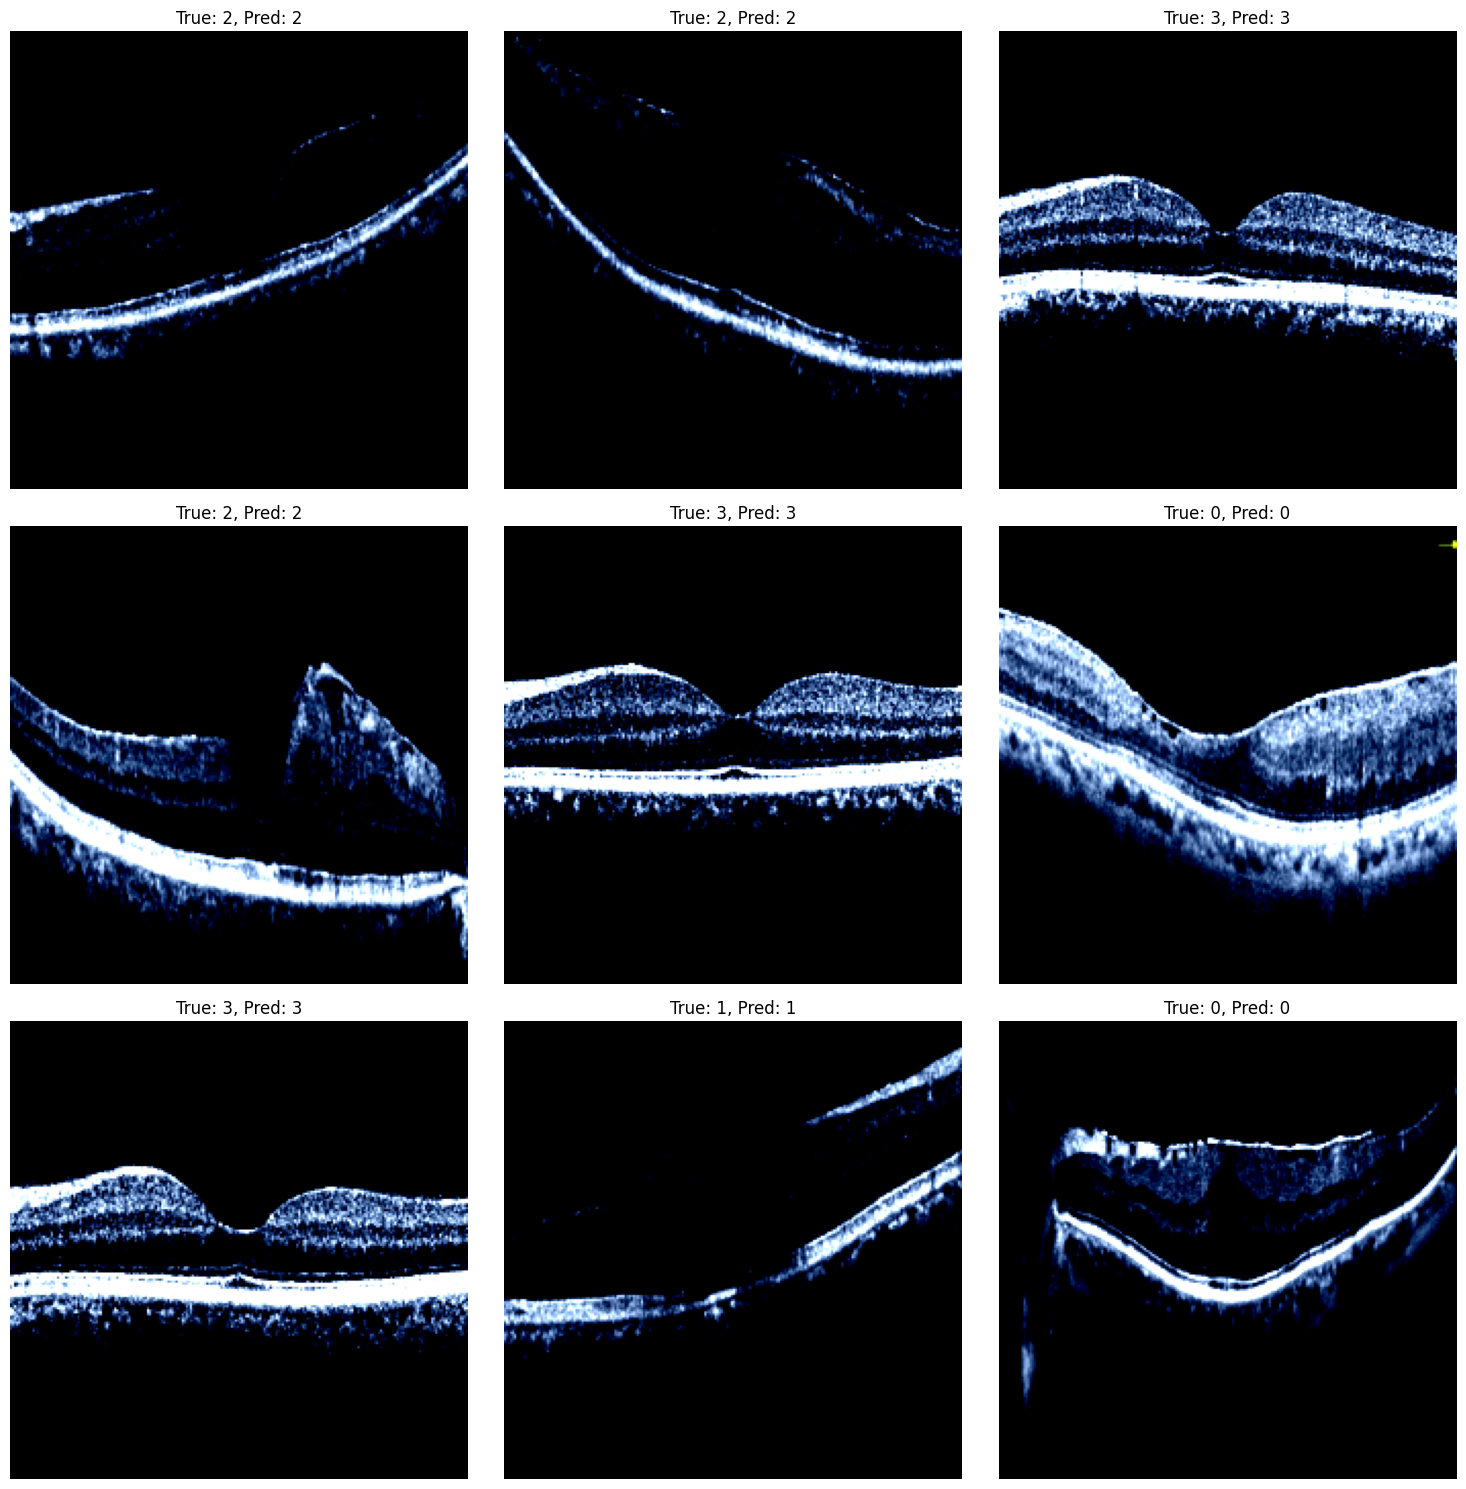

'\nOCT image classification\nlabels - Diseases\n0 - epiretinal membrane (ERM)\n1 - full-thicknes macular hole (FTMH)\n2 - lamellar macular hole (LMH)\n3 - normal OCT\n4 - vitreomacular traction (VMT) \n'

In [ ]:
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)
num_images=9
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(images)  # Get the model predictions
    _, preds = torch.max(outputs, 1)  # Get the predicted class labels

plt.figure(figsize=(15, 15))

for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())  # Move to CPU for visualization
    plt.title(f'True: {labels[i].item()}, Pred: {preds[i].item()}')
    plt.axis('off')

plt.tight_layout()
plt.show()

"""
OCT image classification
labels - Diseases
0 - epiretinal membrane (ERM)
1 - full-thicknes macular hole (FTMH)
2 - lamellar macular hole (LMH)
3 - normal OCT
4 - vitreomacular traction (VMT)
"""
